In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from cornac.data import Reader
import matplotlib.pyplot as plt

# Leer el archivo original de MovieLens 100k con timestamps
columns = ['user', 'item', 'rating', 'timestamp']
df = pd.read_csv('datasets/ml-100k/u.data', sep='\t', names=columns)

# Ordenar los ratings cronológicamente
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Mostrar las primeras filas ordenadas
df.head()

,user,item,rating,timestamp
0,259,255,4,874724710
1,259,286,4,874724727
2,259,298,4,874724754
3,259,185,4,874724781
4,259,173,4,874724843


In [2]:
# Parámetro: número de batches que queremos simular
N_BATCHES = 5

# Calcular el tamaño de cada bloque
batch_size = len(df) // N_BATCHES

# Crear una lista de batches (sub-dataframes)
batches = []
for i in range(N_BATCHES):
    start = i * batch_size
    end = (i + 1) * batch_size if i < N_BATCHES - 1 else len(df)
    batches.append(df.iloc[start:end])

# Verificar tamaño y contenido del primer batch
print(f"Cantidad de ratings por batch: {batch_size}")
batches[0].head()


Cantidad de ratings por batch: 20000


,user,item,rating,timestamp
0,259,255,4,874724710
1,259,286,4,874724727
2,259,298,4,874724754
3,259,185,4,874724781
4,259,173,4,874724843


In [3]:
from cornac.models import MF
from cornac.data import Reader
from cornac.eval_methods import BaseMethod
from cornac.metrics import RMSE, Precision, NDCG

resultados = []

# Iterar desde el segundo batch en adelante
for i in range(1, N_BATCHES):
    # Unir todos los datos disponibles hasta el batch i-1
    train_df = pd.concat(batches[:i])
    
    # El siguiente batch será el conjunto de prueba
    test_df = batches[i]
    
    # Convertir ambos conjuntos a listas de tuplas (usuario, ítem, rating, timestamp)
    train_data = list(train_df.itertuples(index=False, name=None))
    test_data = list(test_df.itertuples(index=False, name=None))
    
    # Usar Cornac para crear el método de evaluación personalizado
    eval_method = BaseMethod.from_splits(
        train_data=train_data,
        test_data=test_data,
        fmt='UIRT',
        verbose=False
    )
    
    # Definir modelo
    model = MF(k=30, learning_rate=0.01, lambda_reg=0.05, max_iter=50, verbose=False)
    model.fit(eval_method.train_set)
    
    # Evaluar el modelo
    metrics = eval_method.evaluate(model, metrics=[
        RMSE(), Precision(k=5), NDCG(k=5)], user_based=True)
    
    # Guardar resultados
    batch_result = {
        'batch': i,
        'RMSE': dict(metrics[0].metric_avg_results)['RMSE'],
        'Precision@5': dict(metrics[0].metric_avg_results)['Precision@5'],
        'NDCG@5': dict(metrics[0].metric_avg_results)['NDCG@5']
    }
    resultados.append(batch_result)

# Mostrar resultados
pd.DataFrame(resultados)

/home/ivan/recommender-system/cornac-venv/lib/python3.12/site-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


,batch,RMSE,Precision@5,NDCG@5
0,1,0.980906,0.055556,0.052756
1,2,1.002008,0.020225,0.020274
2,3,0.987922,0.077419,0.105356
3,4,0.982795,0.021262,0.024091


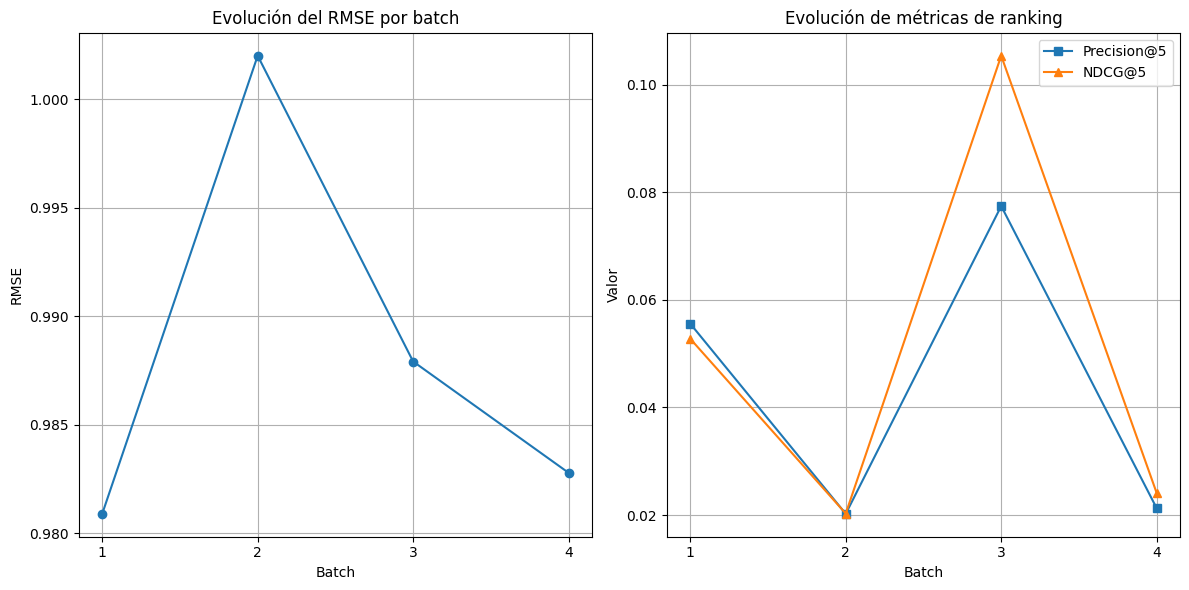

In [4]:
import matplotlib.pyplot as plt

df_resultados = pd.DataFrame(resultados)

plt.figure(figsize=(12, 6))

# Subgráfico para RMSE
plt.subplot(1, 2, 1)
plt.plot(df_resultados['batch'], df_resultados['RMSE'], marker='o', label='RMSE')
plt.title('Evolución del RMSE por batch')
plt.xlabel('Batch')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(df_resultados['batch'])

# Subgráfico para Precision@5 y NDCG@5
plt.subplot(1, 2, 2)
plt.plot(df_resultados['batch'], df_resultados['Precision@5'], marker='s', label='Precision@5')
plt.plot(df_resultados['batch'], df_resultados['NDCG@5'], marker='^', label='NDCG@5')
plt.title('Evolución de métricas de ranking')
plt.xlabel('Batch')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.xticks(df_resultados['batch'])

plt.tight_layout()
plt.show()
